# Preprocessing the data

In [1]:
import pandas as pd

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
train_path = '/Users/cao.yumin/Desktop/DL_fd/Google_Stock_Price_Train.csv'
df = pd.read_csv(train_path)
df

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


### Date colume to time series

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

### 'object' to numeric

In [6]:
df['Close'] = df['Close'].str.replace(',', '').astype(float)
df['Volume'] = df['Volume'].str.replace(',', '').astype(int)

In [7]:
df.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [8]:
# df = df.set_index(['Date'])

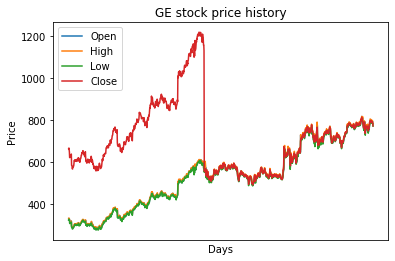

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.xticks(df['Date'])
plt.plot(df['Open'])
plt.plot(df['High'])
plt.plot(df['Low'])
plt.plot(df["Close"])
plt.title('GE stock price history')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

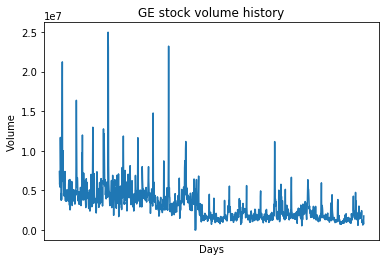

In [10]:
plt.figure()
plt.xticks(df['Date'])
plt.plot(df['Volume'])
plt.title('GE stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

### scale the data

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_data = scaler.fit_transform(df.iloc[:,1:]) 
train_data = torch.FloatTensor(train_data).to(device)
len(train_data),train_data

(1258,
 tensor([[-1.3729, -1.3407, -1.3558, -0.2980,  1.8578],
         [-1.3332, -1.3339, -1.3285, -0.2807,  1.1401],
         [-1.3427, -1.3543, -1.3430, -0.3368,  1.5101],
         ...,
         [ 1.7122,  1.6761,  1.6891,  0.4395, -0.8819],
         [ 1.6439,  1.6218,  1.6606,  0.4258, -1.0620],
         [ 1.6401,  1.6012,  1.6041,  0.3592, -0.6107]]))

### split the training data into train & cross

In [12]:
train_ = train_data[:629]
cross1_ = train_data[629:929]
cross2_ = train_data[929:]

In [13]:
train_,len(train_)

(tensor([[-1.3729, -1.3407, -1.3558, -0.2980,  1.8578],
         [-1.3332, -1.3339, -1.3285, -0.2807,  1.1401],
         [-1.3427, -1.3543, -1.3430, -0.3368,  1.5101],
         ...,
         [ 0.2834,  0.2937,  0.3061, -0.7991, -0.7525],
         [ 0.3164,  0.3005,  0.3309, -0.8011, -0.9248],
         [ 0.3164,  0.2977,  0.3344, -0.7866, -1.0753]]),
 629)

In [14]:
cross1_,len(cross1_)

(tensor([[ 0.3191,  0.3069,  0.3255, -0.8016, -0.9211],
         [ 0.2790,  0.2619,  0.2364, -0.8692, -0.5494],
         [ 0.2391,  0.2436,  0.2579, -0.8390, -0.8982],
         ...,
         [ 0.5763,  0.5795,  0.5355, -0.6069, -0.6406],
         [ 0.5228,  0.5641,  0.5477, -0.5545, -0.5512],
         [ 0.5666,  0.5747,  0.5875, -0.5277, -0.7852]]),
 300)

# Creating the network

In [15]:
def create_sequences(input_data, seq_len):
    seq = []
    L = len(input_data)
    for i in range(L-seq_len):
        train_seq = input_data[i:i+seq_len]
        train_label = input_data[i+seq_len:i+seq_len+1]
        seq.append((train_seq ,train_label))
    return seq
seq_len = 190
train_seq = create_sequences(train_data, seq_len)
print(f'There are {len(train_seq)} training sequences where each sequence has a shape of {train_seq[0][0].shape}')

There are 1068 training sequences where each sequence has a shape of torch.Size([190, 5])


In [16]:
class LSTM_layer(nn.Module): # has 2 layers
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(LSTM_layer,self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
        
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size,output_size)
        
    
    def forward(self,x):
        # x-> (batch_size, sequence, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out_lstm,_ = self.lstm(x, (h0, c0))
        # out_lstm-> (batch_size, sequence, hidden_size)
        out = out_lstm[:,-1,:]
        # out-> (batch_size,hidden_size)
        out = self.fc(out)
        return out

In [17]:
class LSTM_nolayer(nn.Module): # simple LSTM without layer
    def __init__(self,input_size,hidden_siz,output_size):
        super(LSTM_nolayer,self).__init__()
        
        self.hidden_size = hidden_size
        self.input_size = input_size
        
        self.lstm = nn.LSTM(input_size,hidden_size,batch_first=True)
        self.fc = nn.Linear(hidden_size,output_size)
        
    
    def forward(self,x):
        # x-> (batch_size, sequence, input_size)
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        
        out_lstm,_ = self.lstm(x, (h0, c0))
        # out_lstm-> (batch_size, sequence, hidden_size)
        out = out_lstm[:,-1,:]
        # out-> (batch_size,hidden_size)
        out = self.fc(out)
        return out

In [18]:
# example
input_ = train_data[0:9]
input_size = 5
hidden_size = 128
num_layers = 2
output_size = 5
rnn1 = LSTM_layer(input_size,hidden_size,num_layers,output_size)
rnn2 = LSTM_nolayer(input_size,hidden_size,output_size)

input_ = input_.reshape(-1,3,5)
input_,rnn1(input_),rnn2(input_)

(tensor([[[-1.3729, -1.3407, -1.3558, -0.2980,  1.8578],
          [-1.3332, -1.3339, -1.3285, -0.2807,  1.1401],
          [-1.3427, -1.3543, -1.3430, -0.3368,  1.5101]],
 
         [[-1.3525, -1.3672, -1.3644, -0.3912,  0.9890],
          [-1.3940, -1.4096, -1.4589, -0.5581,  3.7533],
          [-1.4489, -1.4525, -1.4732, -0.5540,  2.4929]],
 
         [[-1.4694, -1.4669, -1.4593, -0.5369,  0.7302],
          [-1.4441, -1.4555, -1.4414, -0.5146,  0.2668],
          [-1.4604, -1.4749, -1.4595, -0.5428,  0.6484]]]),
 tensor([[-0.0685, -0.0519, -0.0456, -0.1081,  0.0832],
         [-0.0686, -0.0476, -0.0464, -0.1094,  0.0791],
         [-0.0676, -0.0567, -0.0471, -0.1071,  0.0882]],
        grad_fn=<AddmmBackward>),
 tensor([[-0.0092,  0.0154,  0.0325,  0.0579, -0.0551],
         [-0.0279,  0.0251,  0.0314,  0.0753, -0.0535],
         [-0.0016,  0.0133,  0.0259,  0.0370, -0.0603]],
        grad_fn=<AddmmBackward>))

In [19]:
input_.shape

torch.Size([3, 3, 5])

# Turning learning_rate, hidden_size, layers, sequence_number

In [46]:
criterion = nn.MSELoss().to(device)

lr_list = [0.0001, 0.005, 0.01, 0.1]
hidden_size_list = [64,128,256,512]
sequence_list = [15,30,45,60,90]
num_layers_list = [2,3,4]

# optimizer = torch.optim.Adam(model.parameters(), lr)

# Train the network with single-layer, * using greed search

### find best sequence length

In [41]:
from sklearn.metrics import mean_absolute_error

criterion = nn.MSELoss().to(device)

epochs = 20
recording = []
train_x = train_
hidden_size = 128
inputs_size = 5
for j in sequence_list: # find the best sequence_lenth
    seq_len = j
    train_seq = create_sequences(train_x, seq_len)
    model_nolayer = LSTM_nolayer(inputs_size,hidden_size,output_size).to(device)
    optimizer = torch.optim.Adam(model_nolayer.parameters(), 0.005)
    for i in range(epochs):
        for s, (seq, labels) in enumerate(train_seq):
            seq = seq.to(device)
            labels = labels.to(device)
    #         print('labels',labels)
            optimizer.zero_grad()
            x = seq.reshape(-1,seq_len,5)

            y_pred = model_nolayer(x)
    #         print('y_pred',y_pred)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()

    result = 0
    for test_x in [cross1_,cross2_]:
        test_seq = create_sequences(test_x, seq_len)
        real_labels = []
        predicted_labels = []
        with torch.no_grad():
            for m, (seq, label) in enumerate(test_seq):
                seq = seq.to(device)
                label = label.to(device)
                real_labels.append(label[0].numpy())
                x = seq.reshape(-1,seq_len,5)
                predicted_labels.append(model_nolayer(x)[0].numpy())  
#         print(len(predicted_labels),predicted_labels)
#         print(len(real_labels),real_labels)
#         print('****')
        r = mean_absolute_error(real_labels, predicted_labels)
        result = result+r
    result /= 2
    print('--',result)
    recording.append([result,seq_len])
    
temp = sorted(recording)
best_seq_len = temp[0][1]
best_seq_len

-- 0.20584889501333237
-- 0.44109421968460083
-- 0.5691082701086998
-- 0.3761592358350754
-- 0.6492492109537125


15

### find best hidden size

In [44]:
epochs = 20
recording = []
train_x = train_
inputs_size = 5
seq_len = 15
for j in hidden_size_list: # find the best sequence_lenth
    hidden_size = j
    train_seq = create_sequences(train_x, seq_len)
    model_nolayer = LSTM_nolayer(inputs_size,hidden_size,output_size).to(device)
    optimizer = torch.optim.Adam(model_nolayer.parameters(), 0.005)
    for i in range(epochs):
        for s, (seq, labels) in enumerate(train_seq):
            seq = seq.to(device)
            labels = labels.to(device)
    #         print('labels',labels)
            optimizer.zero_grad()
            x = seq.reshape(-1,seq_len,5)

            y_pred = model_nolayer(x)
    #         print('y_pred',y_pred)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()

    result = 0
    for test_x in [cross1_,cross2_]:
        test_seq = create_sequences(test_x, seq_len)
        real_labels = []
        predicted_labels = []
        with torch.no_grad():
            for m, (seq, label) in enumerate(test_seq):
                seq = seq.to(device)
                label = label.to(device)
                real_labels.append(label[0].numpy())
                x = seq.reshape(-1,seq_len,5)
                predicted_labels.append(model_nolayer(x)[0].numpy())  
#         print(len(predicted_labels),predicted_labels)
#         print(len(real_labels),real_labels)
#         print('****')
        r = mean_absolute_error(real_labels, predicted_labels)
        result = result+r
    result /= 2
    print('--',result)
    recording.append([result,hidden_size])
    
temp = sorted(recording)
best_hidden = temp[0][1]
best_hidden

-- 0.5864179953932762
-- 0.47362641990184784
-- 0.39308302104473114
-- 0.4078792780637741


256

### find best learning rate

In [45]:
epochs = 20
recording = []
train_x = train_
inputs_size = 5
seq_len = 15
hidden_size = 256
for j in lr_list: # find the best sequence_lenth
    lr = j
    train_seq = create_sequences(train_x, seq_len)
    model_nolayer = LSTM_nolayer(inputs_size,hidden_size,output_size).to(device)
    optimizer = torch.optim.Adam(model_nolayer.parameters(), lr)
    for i in range(epochs):
        for s, (seq, labels) in enumerate(train_seq):
            seq = seq.to(device)
            labels = labels.to(device)
    #         print('labels',labels)
            optimizer.zero_grad()
            x = seq.reshape(-1,seq_len,5)

            y_pred = model_nolayer(x)
    #         print('y_pred',y_pred)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()

    result = 0
    for test_x in [cross1_,cross2_]:
        test_seq = create_sequences(test_x, seq_len)
        real_labels = []
        predicted_labels = []
        with torch.no_grad():
            for m, (seq, label) in enumerate(test_seq):
                seq = seq.to(device)
                label = label.to(device)
                real_labels.append(label[0].numpy())
                x = seq.reshape(-1,seq_len,5)
                predicted_labels.append(model_nolayer(x)[0].numpy())  
#         print(len(predicted_labels),predicted_labels)
#         print(len(real_labels),real_labels)
#         print('****')
        r = mean_absolute_error(real_labels, predicted_labels)
        result = result+r
    result /= 2
    print('--',result)
    recording.append([result,lr])
    
temp = sorted(recording)
best_lr = temp[0][1]
best_lr

-- 0.48425740748643875
-- 0.388694703578949
-- 0.3115990236401558
-- 1.2556000053882599


0.01

### single layer & multi layers

In [47]:
epochs = 20
recording = []
train_x = train_
inputs_size = 5
seq_len = 15
hidden_size = 256
lr = 0.01

''' single layer'''
train_seq = create_sequences(train_x, seq_len)
model_nolayer = LSTM_nolayer(inputs_size,hidden_size,output_size).to(device)
optimizer = torch.optim.Adam(model_nolayer.parameters(), lr)
for i in range(epochs):
    for s, (seq, labels) in enumerate(train_seq):
        seq = seq.to(device)
        labels = labels.to(device)
#         print('labels',labels)
        optimizer.zero_grad()
        x = seq.reshape(-1,seq_len,5)

        y_pred = model_nolayer(x)
#         print('y_pred',y_pred)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()

result = 0
for test_x in [cross1_,cross2_]:
    test_seq = create_sequences(test_x, seq_len)
    real_labels = []
    predicted_labels = []
    with torch.no_grad():
        for m, (seq, label) in enumerate(test_seq):
            seq = seq.to(device)
            label = label.to(device)
            real_labels.append(label[0].numpy())
            x = seq.reshape(-1,seq_len,5)
            predicted_labels.append(model_nolayer(x)[0].numpy())  
#         print(len(predicted_labels),predicted_labels)
#         print(len(real_labels),real_labels)
#         print('****')
    r = mean_absolute_error(real_labels, predicted_labels)
    result = result+r
result /= 2
print('--',result)
recording.append([result,'single'])

''' multi layers'''
for j in num_layers_list: # find the best sequence_lenth
    num_layers = j
    train_seq = create_sequences(train_x, seq_len)
    model_layer = LSTM_layer(inputs_size,hidden_size,num_layers,output_size).to(device)
    optimizer = torch.optim.Adam(model_layer.parameters(), lr)
    for i in range(epochs):
        for s, (seq, labels) in enumerate(train_seq):
            seq = seq.to(device)
            labels = labels.to(device)
    #         print('labels',labels)
            optimizer.zero_grad()
            x = seq.reshape(-1,seq_len,5)

            y_pred = model_layer(x)
    #         print('y_pred',y_pred)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()

    result = 0
    for test_x in [cross1_,cross2_]:
        test_seq = create_sequences(test_x, seq_len)
        real_labels = []
        predicted_labels = []
        with torch.no_grad():
            for m, (seq, label) in enumerate(test_seq):
                seq = seq.to(device)
                label = label.to(device)
                real_labels.append(label[0].numpy())
                x = seq.reshape(-1,seq_len,5)
                predicted_labels.append(model_layer(x)[0].numpy())  
#         print(len(predicted_labels),predicted_labels)
#         print(len(real_labels),real_labels)
#         print('****')
        r = mean_absolute_error(real_labels, predicted_labels)
        result = result+r
    result /= 2
    print('--',result)
    recording.append([result,'multi '+str(j)])
    

temp = sorted(recording)
best_layer = temp[0][1]
best_layer

-- 0.5493039265275002
-- 1.0446996241807938
-- 0.5689667016267776
-- 0.571867935359478


'single'

# Plot with train_data

In [49]:
epochs = 40
train_x = train_data
inputs_size = 5
seq_len = 15
hidden_size = 256
lr = 0.01

''' single layer'''
train_seq = create_sequences(train_x, seq_len)
model_nolayer = LSTM_nolayer(inputs_size,hidden_size,output_size).to(device)
optimizer = torch.optim.Adam(model_nolayer.parameters(), lr)

loss_history = []
running_loss = []
loss_history2 = []
running_loss2 = []
for i in range(epochs):
    
    for j, (seq, labels) in enumerate(train_seq):
        seq = seq.to(device)
        labels = labels.to(device)
#         print('labels',labels)
        optimizer.zero_grad()
        x = seq.reshape(-1,seq_len,5)

        y_pred = model_nolayer(x)
#         print('y_pred',y_pred)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

        if j % 50 == 0:
            avg_loss = sum(running_loss) / 50
            print(f'Epoch {i+1:3}, iteration {j:5}, loss: {avg_loss}')
            loss_history.append(avg_loss)
            running_loss = []
#         print('---------')

Epoch   1, iteration     0, loss: 0.0712075662612915
Epoch   1, iteration    50, loss: 0.23867351482622326
Epoch   1, iteration   100, loss: 0.39079242226493077
Epoch   1, iteration   150, loss: 0.16785656990832648
Epoch   1, iteration   200, loss: 0.7624888449988794
Epoch   1, iteration   250, loss: 0.16696690055076033
Epoch   1, iteration   300, loss: 0.07563887806143611
Epoch   1, iteration   350, loss: 0.0889061029421282
Epoch   1, iteration   400, loss: 0.15648986902087927
Epoch   1, iteration   450, loss: 0.42473792005213906
Epoch   1, iteration   500, loss: 0.04964547769981437
Epoch   1, iteration   550, loss: 0.4739748826401774
Epoch   1, iteration   600, loss: 0.15539973618928343
Epoch   1, iteration   650, loss: 0.028998272984754294
Epoch   1, iteration   700, loss: 0.03779653768520802
Epoch   1, iteration   750, loss: 0.027259939705836587
Epoch   1, iteration   800, loss: 0.028545678870286792
Epoch   1, iteration   850, loss: 0.023798396218335256
Epoch   1, iteration   900, 

Epoch   7, iteration   100, loss: 0.23602767932228744
Epoch   7, iteration   150, loss: 0.10932162363198586
Epoch   7, iteration   200, loss: 0.5377892051450908
Epoch   7, iteration   250, loss: 0.16046111763920634
Epoch   7, iteration   300, loss: 0.06111962836701423
Epoch   7, iteration   350, loss: 0.07644329153932632
Epoch   7, iteration   400, loss: 0.13031123227905483
Epoch   7, iteration   450, loss: 0.3333318744669668
Epoch   7, iteration   500, loss: 0.06987229513353668
Epoch   7, iteration   550, loss: 0.22298614900093525
Epoch   7, iteration   600, loss: 0.0563343529147096
Epoch   7, iteration   650, loss: 0.02247203831328079
Epoch   7, iteration   700, loss: 0.024173277367372067
Epoch   7, iteration   750, loss: 0.01789883290650323
Epoch   7, iteration   800, loss: 0.020117959242197683
Epoch   7, iteration   850, loss: 0.018555547518189996
Epoch   7, iteration   900, loss: 0.10174370161956175
Epoch   7, iteration   950, loss: 0.04979041341226548
Epoch   7, iteration  1000, 

Epoch  13, iteration   200, loss: 0.452165729975095
Epoch  13, iteration   250, loss: 0.15163257574196906
Epoch  13, iteration   300, loss: 0.06417241064627888
Epoch  13, iteration   350, loss: 0.0729569677816471
Epoch  13, iteration   400, loss: 0.10914128402248024
Epoch  13, iteration   450, loss: 0.3124040685908403
Epoch  13, iteration   500, loss: 0.07829295932780951
Epoch  13, iteration   550, loss: 0.18076869460521267
Epoch  13, iteration   600, loss: 0.04176477102795616
Epoch  13, iteration   650, loss: 0.023328928605187683
Epoch  13, iteration   700, loss: 0.02362637276237365
Epoch  13, iteration   750, loss: 0.016642940675956196
Epoch  13, iteration   800, loss: 0.019361070864833893
Epoch  13, iteration   850, loss: 0.015300022233277559
Epoch  13, iteration   900, loss: 0.07515124616125832
Epoch  13, iteration   950, loss: 0.04537107480922714
Epoch  13, iteration  1000, loss: 0.019514150524046273
Epoch  13, iteration  1050, loss: 0.033894910297822205
Epoch  13, iteration  1100

Epoch  19, iteration   300, loss: 0.06627813870552927
Epoch  19, iteration   350, loss: 0.07736857866169884
Epoch  19, iteration   400, loss: 0.11868154414230958
Epoch  19, iteration   450, loss: 0.3099617107619997
Epoch  19, iteration   500, loss: 0.05794523261720315
Epoch  19, iteration   550, loss: 0.1699616687046364
Epoch  19, iteration   600, loss: 0.027431611643405632
Epoch  19, iteration   650, loss: 0.035453926926129496
Epoch  19, iteration   700, loss: 0.02151185194205027
Epoch  19, iteration   750, loss: 0.018693846936221236
Epoch  19, iteration   800, loss: 0.023486935378750785
Epoch  19, iteration   850, loss: 0.01438775757473195
Epoch  19, iteration   900, loss: 0.05834454985008051
Epoch  19, iteration   950, loss: 0.04836645424598828
Epoch  19, iteration  1000, loss: 0.019562015850970057
Epoch  19, iteration  1050, loss: 0.031450697856489566
Epoch  19, iteration  1100, loss: 0.02998932005604729
Epoch  19, iteration  1150, loss: 0.021795897028641775
Epoch  19, iteration  1

Epoch  25, iteration   400, loss: 0.09428942407714203
Epoch  25, iteration   450, loss: 0.28386205674847587
Epoch  25, iteration   500, loss: 1.5648527302546427
Epoch  25, iteration   550, loss: 0.6582516098022461
Epoch  25, iteration   600, loss: 0.1766242239670828
Epoch  25, iteration   650, loss: 0.026452283845865166
Epoch  25, iteration   700, loss: 0.020860422974219545
Epoch  25, iteration   750, loss: 0.017731339747551828
Epoch  25, iteration   800, loss: 0.01269561960361898
Epoch  25, iteration   850, loss: 0.013242489162948914
Epoch  25, iteration   900, loss: 0.044253067531972196
Epoch  25, iteration   950, loss: 0.03299603443592787
Epoch  25, iteration  1000, loss: 0.01778509996132925
Epoch  25, iteration  1050, loss: 0.028300481460173613
Epoch  25, iteration  1100, loss: 0.024753485066466966
Epoch  25, iteration  1150, loss: 0.0222489073802717
Epoch  25, iteration  1200, loss: 0.013097079889848828
Epoch  26, iteration     0, loss: 0.04233001450076699
Epoch  26, iteration    

Epoch  31, iteration   500, loss: 0.0491415679291822
Epoch  31, iteration   550, loss: 0.5820710196439177
Epoch  31, iteration   600, loss: 0.20459703337284738
Epoch  31, iteration   650, loss: 0.03559917559265159
Epoch  31, iteration   700, loss: 0.020349166471860372
Epoch  31, iteration   750, loss: 0.015647640232346022
Epoch  31, iteration   800, loss: 0.01419824292010162
Epoch  31, iteration   850, loss: 0.013523350918549113
Epoch  31, iteration   900, loss: 0.05269094152143225
Epoch  31, iteration   950, loss: 0.030329114531632513
Epoch  31, iteration  1000, loss: 0.01750427543418482
Epoch  31, iteration  1050, loss: 0.023968502080533652
Epoch  31, iteration  1100, loss: 0.022071895107510498
Epoch  31, iteration  1150, loss: 0.021730856719368603
Epoch  31, iteration  1200, loss: 0.011072201006463729
Epoch  32, iteration     0, loss: 0.053039934867992994
Epoch  32, iteration    50, loss: 0.09485764887183905
Epoch  32, iteration   100, loss: 0.2548715608287603
Epoch  32, iteration  

Epoch  37, iteration   600, loss: 0.02628916230984032
Epoch  37, iteration   650, loss: 0.02923045523755718
Epoch  37, iteration   700, loss: 0.021664420162560417
Epoch  37, iteration   750, loss: 0.01760213215369731
Epoch  37, iteration   800, loss: 0.014435461449902504
Epoch  37, iteration   850, loss: 0.01370718927239068
Epoch  37, iteration   900, loss: 0.04171854519401677
Epoch  37, iteration   950, loss: 0.03478121866006404
Epoch  37, iteration  1000, loss: 0.016791351275460328
Epoch  37, iteration  1050, loss: 0.02520080073038116
Epoch  37, iteration  1100, loss: 0.02351275827968493
Epoch  37, iteration  1150, loss: 0.02378676745342091
Epoch  37, iteration  1200, loss: 0.014067189627676271
Epoch  38, iteration     0, loss: 0.054447949471650645
Epoch  38, iteration    50, loss: 0.10681913130450994
Epoch  38, iteration   100, loss: 0.17474152285605668
Epoch  38, iteration   150, loss: 0.09378972439910285
Epoch  38, iteration   200, loss: 0.4292290265497286
Epoch  38, iteration   2

Text(0, 0.5, 'loss')

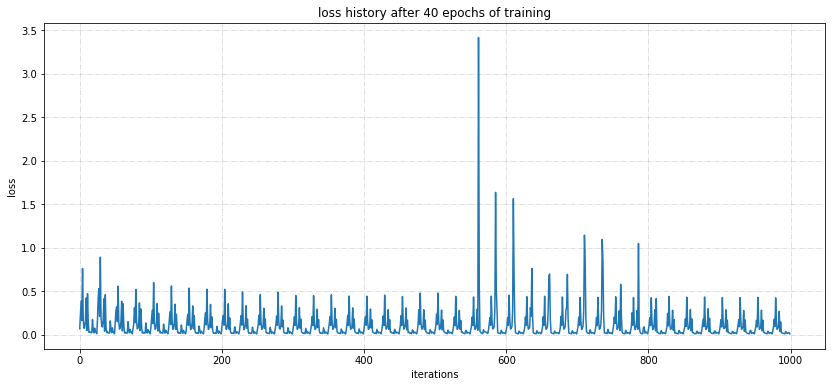

In [50]:
fig, ax1 = plt.subplots(1, 1, figsize=(14,6))

plt.title(f'loss history after {epochs} epochs of training')
ax1.plot(loss_history)
ax1.grid(alpha=.5, linestyle='-.')
plt.xlabel('iterations')
plt.ylabel('loss')

# Test data

In [51]:
test_path = '/Users/cao.yumin/Desktop/DL_fd/Google_Stock_Price_Test.csv'
df_test = pd.read_csv(test_path)
df_test

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"
5,1/10/2017,807.86,809.13,803.51,804.79,"1,176,800"
6,1/11/2017,805.00,808.15,801.37,807.91,"1,065,900"
7,1/12/2017,807.14,807.39,799.17,806.36,"1,353,100"
8,1/13/2017,807.48,811.22,806.69,807.88,"1,099,200"
9,1/17/2017,807.08,807.14,800.37,804.61,"1,362,100"


In [53]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    20 non-null     datetime64[ns]
 1   Open    20 non-null     float64       
 2   High    20 non-null     float64       
 3   Low     20 non-null     float64       
 4   Close   20 non-null     float64       
 5   Volume  20 non-null     object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 1.1+ KB


In [54]:
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test['Volume'] = df_test['Volume'].str.replace(',', '').astype(int)

In [55]:
test_data = scaler.fit_transform(df_test.iloc[:,1:]) 
test_data = torch.FloatTensor(test_data).to(device)

In [68]:
new_data = df.iloc[-15:,1:].append(df_test.iloc[:,1:],ignore_index = True)

In [70]:
new_data = scaler.fit_transform(new_data)
new_data = torch.FloatTensor(new_data).to(device)

In [71]:
final_test_seq_before = create_sequences(new_data, seq_len)
real_labels = []
predicted_labels = []
with torch.no_grad():
    for m, (seq, label) in enumerate(final_test_seq_before):
        seq = seq.to(device)
        label = label.to(device)
        real_labels.append(label[0].numpy())
        x = seq.reshape(-1,seq_len,5)
        predicted_labels.append(model_nolayer(x)[0].numpy())  
#         print(len(predicted_labels),predicted_labels)
#         print(len(real_labels),real_labels)
#         print('****')
r = mean_absolute_error(real_labels, predicted_labels)
r

0.7375066

In [74]:
real_labels,predicted_labels

([array([-1.5292645 , -1.0937215 , -1.4882617 , -1.0474164 ,  0.16036312],
        dtype=float32),
  array([-0.85914993, -0.97119606, -0.9266288 , -0.99181956, -0.7727196 ],
        dtype=float32),
  array([-1.0191354 , -0.7462078 , -0.78469443, -0.4709643 , -0.35400614],
        dtype=float32),
  array([-0.37498343,  0.21536641, -0.23679715,  0.41639158,  0.13305572],
        dtype=float32),
  array([ 0.40669987,  0.3636867 ,  0.57436556,  0.45296848, -0.45429298],
        dtype=float32),
  array([ 0.5091467 ,  0.30349877,  0.6262555 ,  0.31690237, -0.6069589 ],
        dtype=float32),
  array([ 0.3084632 ,  0.2332795 ,  0.46295467,  0.5451423 , -0.7840578 ],
        dtype=float32),
  array([ 0.45862496,  0.17882372,  0.2950753 ,  0.43175387, -0.3254212 ],
        dtype=float32),
  array([ 0.48248243,  0.45325214,  0.8689176 ,  0.5429477 , -0.73088026],
        dtype=float32),
  array([ 0.4544148 ,  0.16091065,  0.38664585,  0.3037347 , -0.3110489 ],
        dtype=float32),
  array([ 

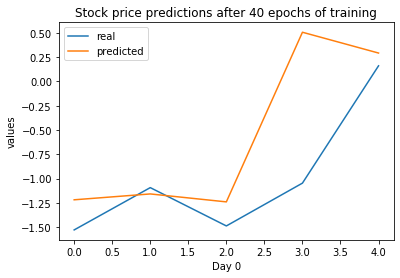

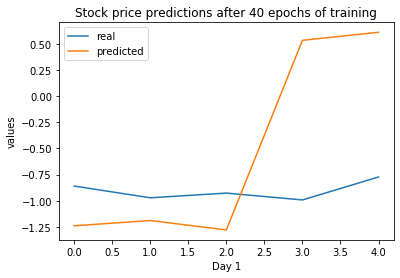

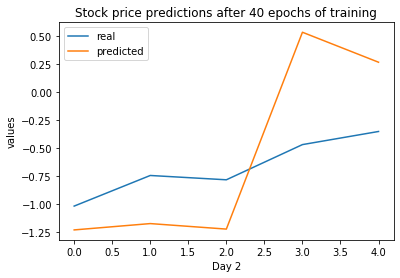

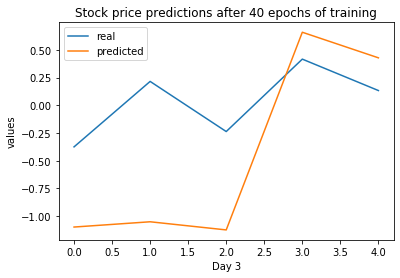

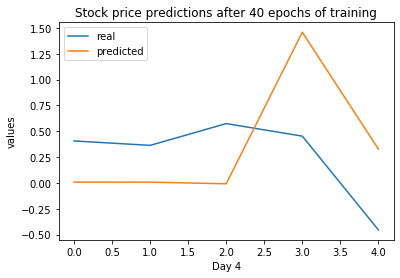

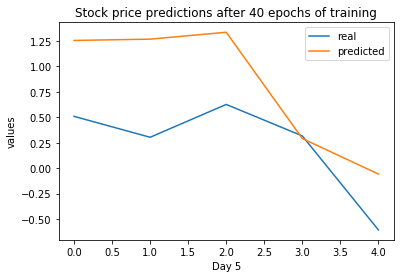

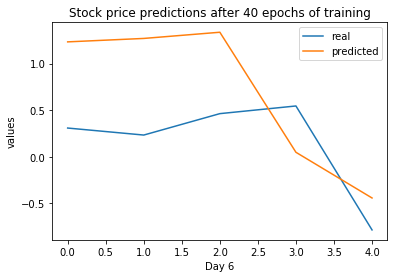

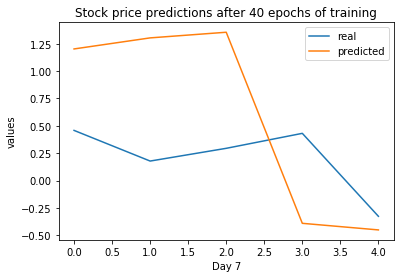

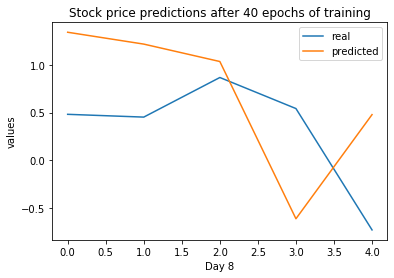

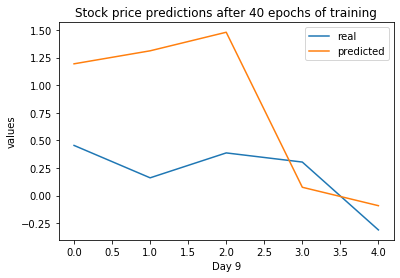

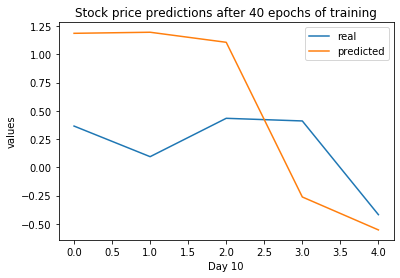

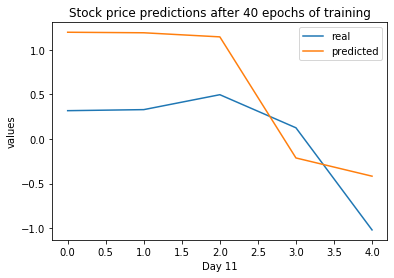

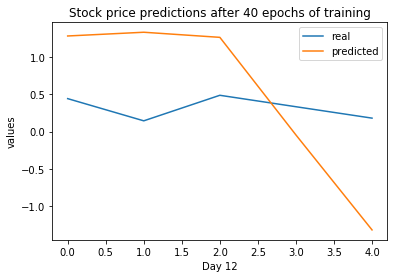

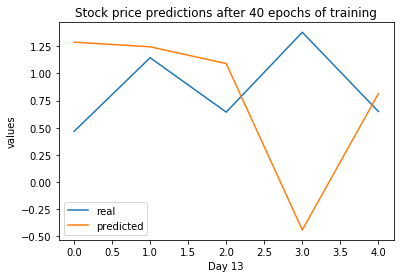

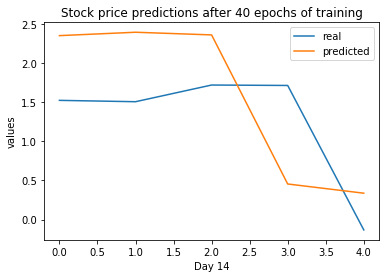

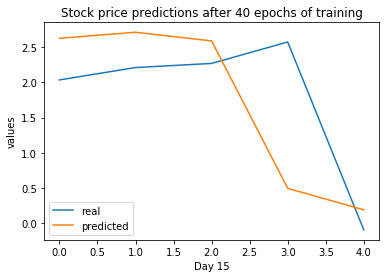

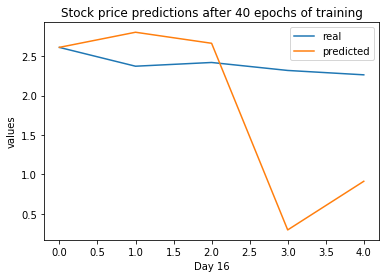

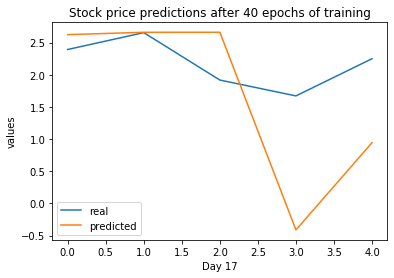

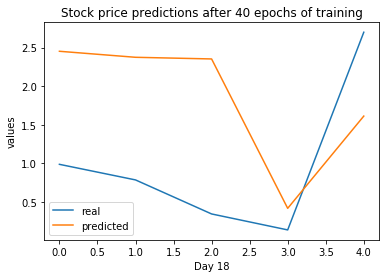

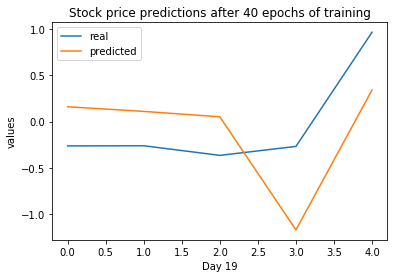

In [75]:
for i in range(len(real_labels)):
    plt.figure()
    plt.title(f'Stock price predictions after 40 epochs of training')
    plt.xlabel('Day '+str(i))
    plt.ylabel('values')
    plt.plot(real_labels[i], label='real')
    plt.plot(predicted_labels[i], label='predicted')
    plt.legend()

In [73]:
len(real_labels)

20